### Generalized additive model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import itertools
from itertools import combinations
from scipy import spatial
import pickle as pickle
import gudhi
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
import warnings

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Import the dataset

In [2]:
washingtonDcSviRaw = gpd.read_file('./data/processed data/SVI2020 WashingtonDC counties with death rate/SVI2020_WashingtonDC_counties_with_death_rate.shp')

In [3]:
# reaname od_deaths_ column to deaths_rate
washingtonDcSviRaw = washingtonDcSviRaw.rename(columns={'od_deaths_':'death_rate'})

##### Filtering the raw variables with overdose death rate

In [4]:
selectedVariables = ['EP_POV150','EP_UNEMP','EP_HBURD','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ','death_rate']

In [5]:
selectedVariablesWithoutY = ['EP_POV150','EP_UNEMP','EP_HBURD','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ']

In [6]:
# filter metro_svi_deaths dataframe to include only the selected variables and od_deaths_per_1000
metroSviMultipleVariablesDf = washingtonDcSviRaw[selectedVariables]

In [7]:
metroSviMultipleVariablesDf.head(3)

EP_POV150  EP_UNEMP  EP_HBURD  EP_NOHSDP  EP_UNINSUR  EP_AGE65  EP_AGE17  \
0       21.3       7.1      27.2        8.1         3.7      12.2      18.0   
1        8.0       3.8      19.0        5.7         3.3      14.9      23.2   
2       10.9       4.4      21.8        6.4         4.2      12.5      24.0   

   EP_DISABL  EP_SNGPNT  EP_LIMENG  EP_MINRTY  EP_MUNIT  EP_MOBILE  EP_CROWD  \
0       11.4        6.9        2.4       63.3      46.8        0.1       3.6   
1        9.9        4.6        0.3       22.4       3.7        0.9       0.5   
2        9.9        8.2        1.0       61.7       5.8        0.9       1.8   

   EP_NOVEH  EP_GROUPQ  death_rate  
0      35.4        5.6    0.615407  
1       2.8        0.6    0.358330  
2       3.2        1.3    0.371637

In [8]:
#define predictor and response variables
X = metroSviMultipleVariablesDf.drop('death_rate', axis=1)
y = metroSviMultipleVariablesDf['death_rate']

Main parameters to keep in mind are:

n_splines , lam , and constraints

n_splines refers to the number of splines to use in each of the smooth function that is going to be fitted.

lam is the penalization term that is multiplied to the second derivative in the overall objective function.

constraints is a list of constraints that allows the user to specify whether a function should have a monotonically constraint. This needs to be a string in [‘convex’, ‘concave’, ‘monotonic_inc’, ‘monotonic_dec’,’circular’, ‘none’]

#### Model 1 - Default model 

In [10]:
from pygam import LinearGAM

In [11]:
gam = LinearGAM().fit(X.values, y.values)

In [12]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      8.0356
Link Function:                     IdentityLink Log Likelihood:                                  -249.4827
Number of Samples:                           25 AIC:                                              517.0367
                                                AICc:                                             529.1559
                                                GCV:                                                  0.06
                                                Scale:                                              0.0268
                                                Pseudo R-Squared:                                   0.4676
Feature Function                  Lam

/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_60885/3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [13]:
featureNames = X.columns

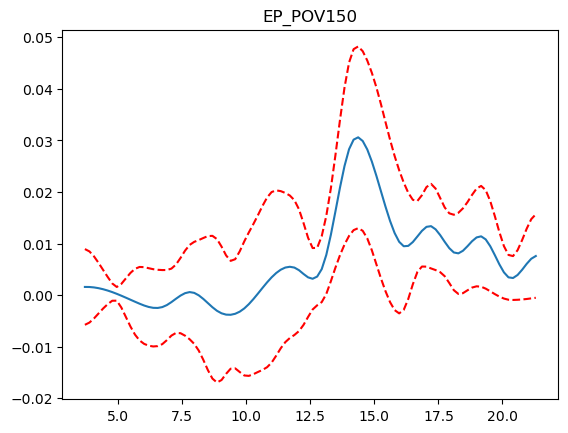

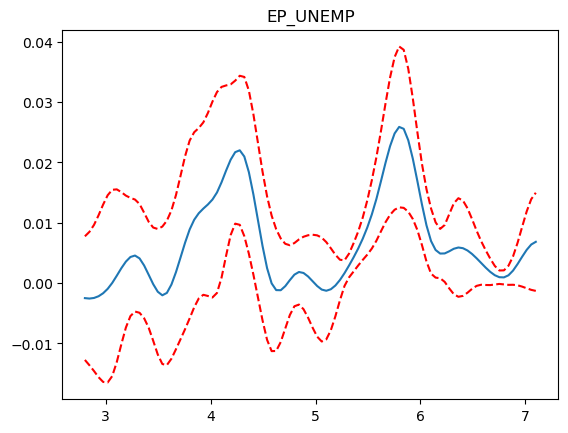

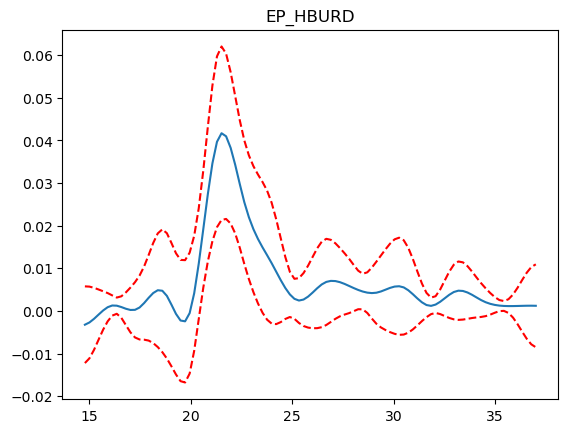

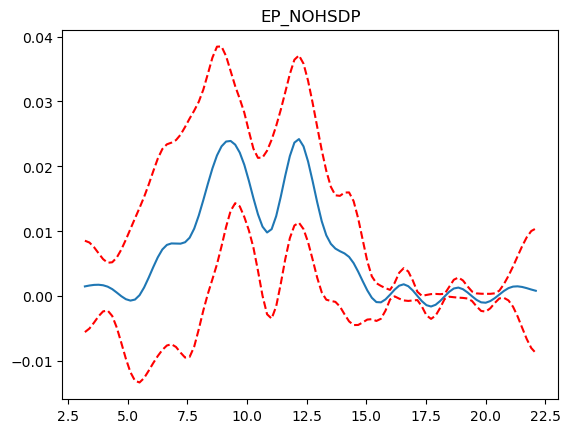

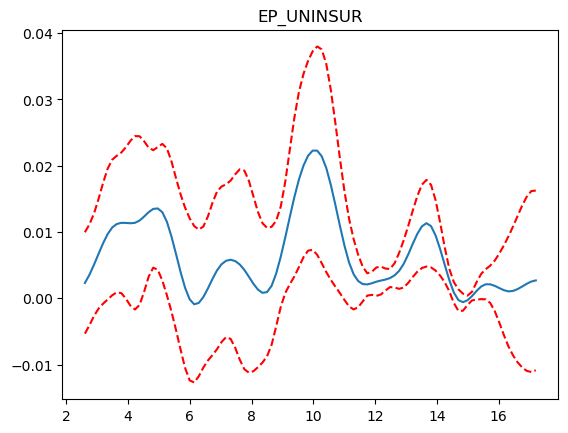

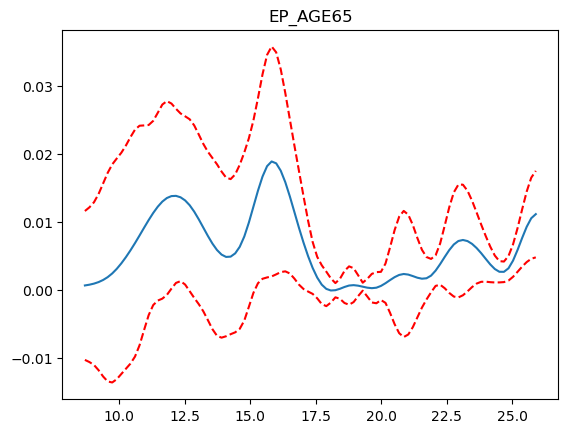

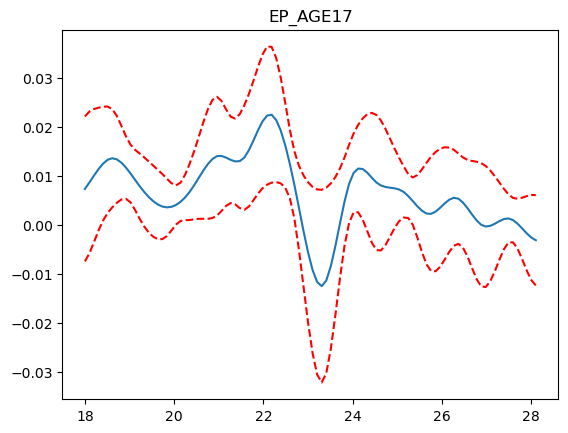

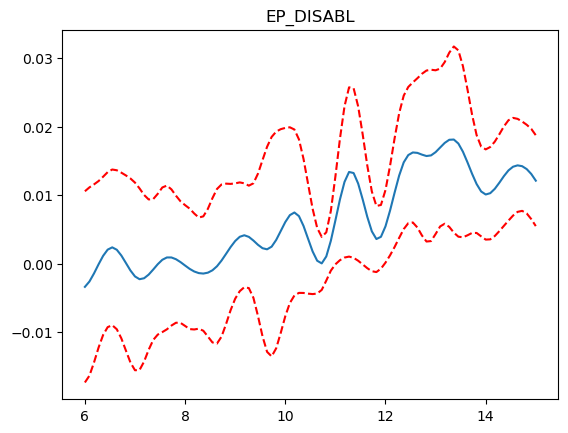

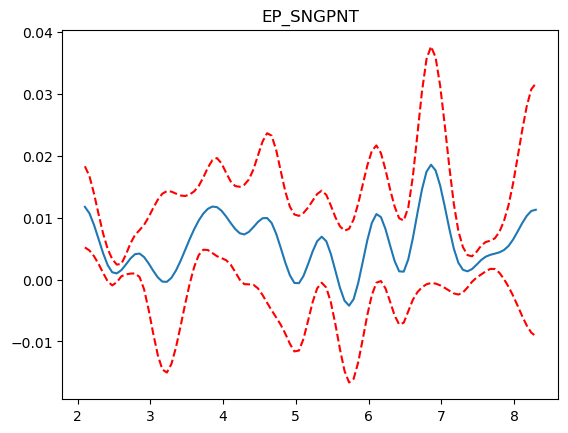

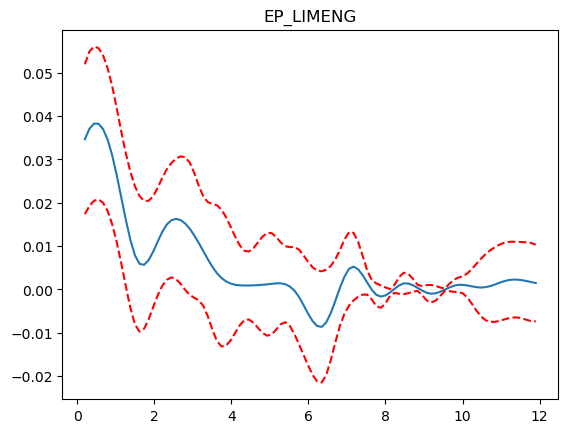

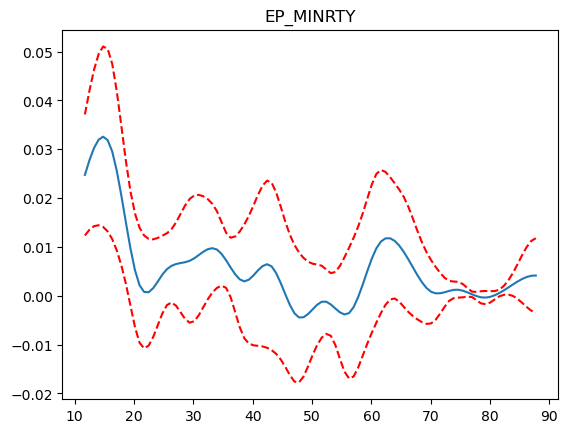

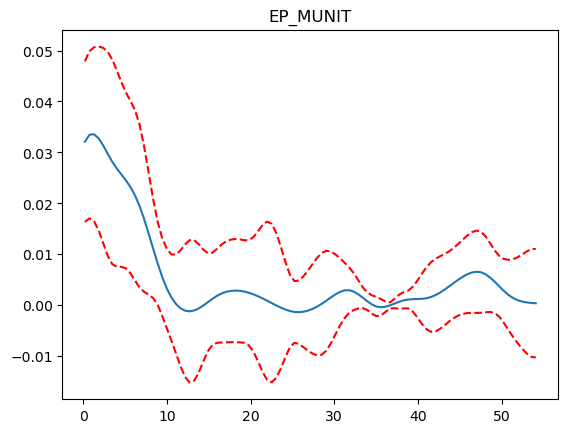

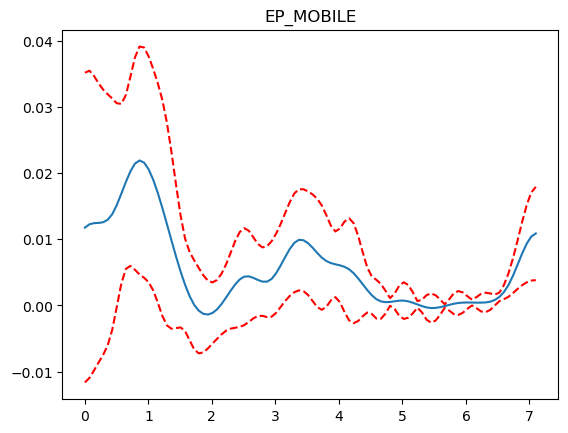

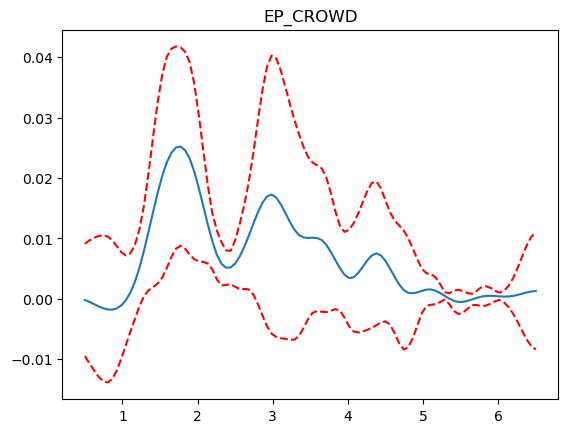

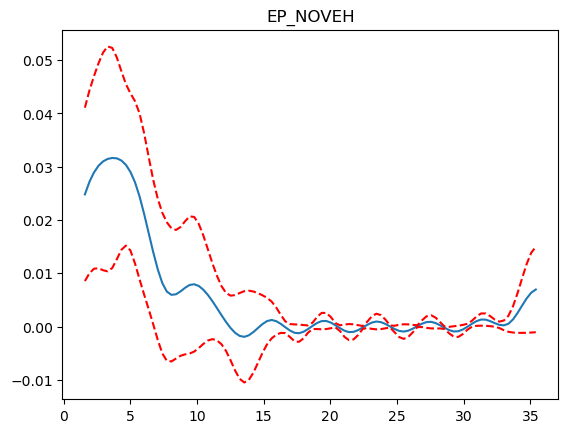

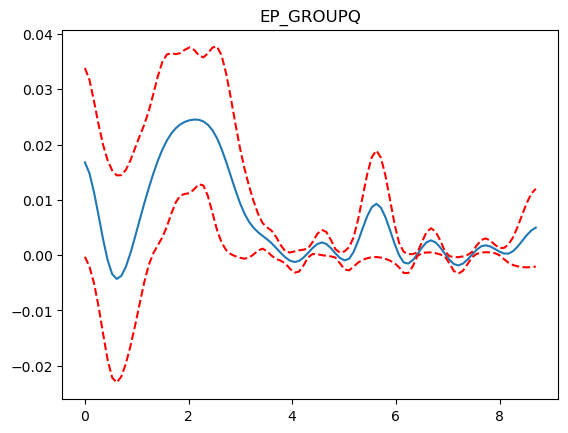

In [14]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(featureNames[i])
    # plt.title(repr(term))
    plt.show()

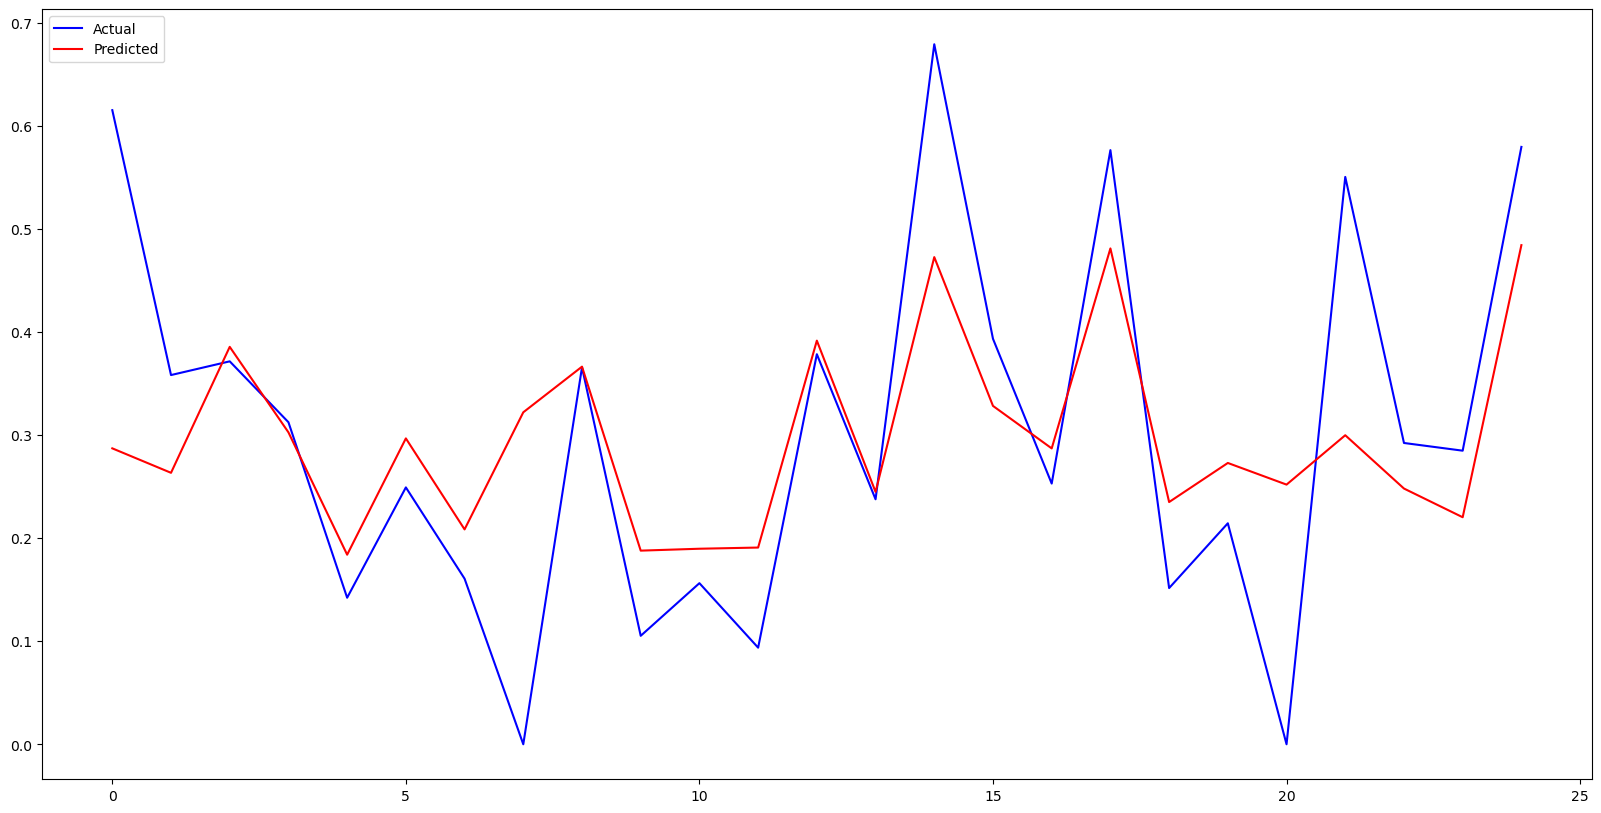

In [15]:
# plot both actual and predicted values on the same graph
y.plot(figsize=(20,10), color='blue', label='Actual')
plt.plot(gam.predict(X), color='red', label='Predicted')
plt.legend(loc='upper left')
plt.show()

#### Model 2 - using grid search

In [27]:
dist = np.random.uniform(1e-3,1e3,(100, 16))
n_splines_to_test = 25

In [28]:
gam = LinearGAM(n_splines=n_splines_to_test).gridsearch(X.values, y.values, lam=dist)

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  1% (1 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:32
  2% (2 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:23
  3% (3 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:23
  4% (4 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:23
  5% (5 of 100) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:22
  6% (6 of 100) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:22
  7% (7 of 100) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:21
  8% (8 of 100) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:20
  9% (9 of 100) |##                      | Elapsed Time: 0:00:01 ETA:   0:00:20
 10% (10 of 100) |##                     | Elapsed Time: 0:00:02 ETA:   0:00:19
 11% (11 of 100) |##                     | Elapsed Time: 0:00:02 ETA:   0:00:18
 12% (12 of 100) |##                    

In [29]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      0.0003
Link Function:                     IdentityLink Log Likelihood:                                   -71.1817
Number of Samples:                           25 AIC:                                              144.3639
                                                AICc:                                             144.5379
                                                GCV:                                                0.1247
                                                Scale:                                              0.1247
                                                Pseudo R-Squared:                                   -2.656
Feature Function                  Lam

/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_60885/3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


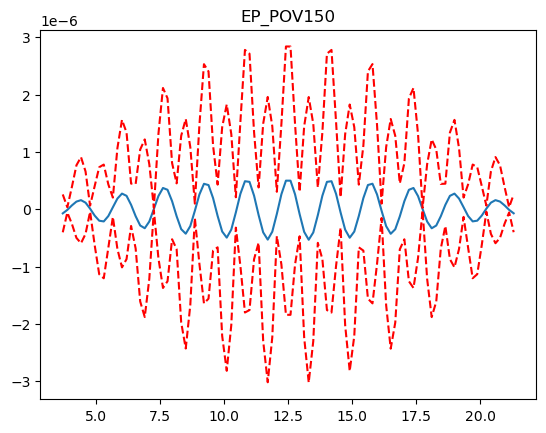

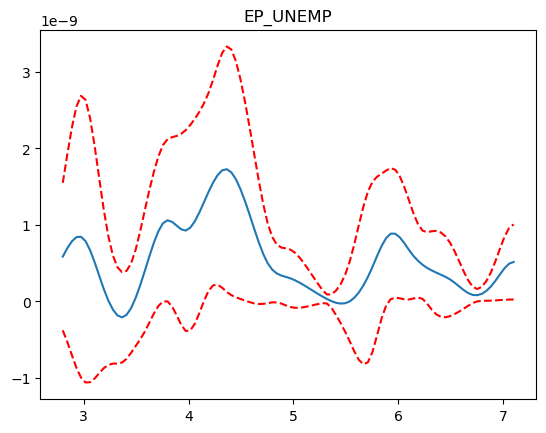

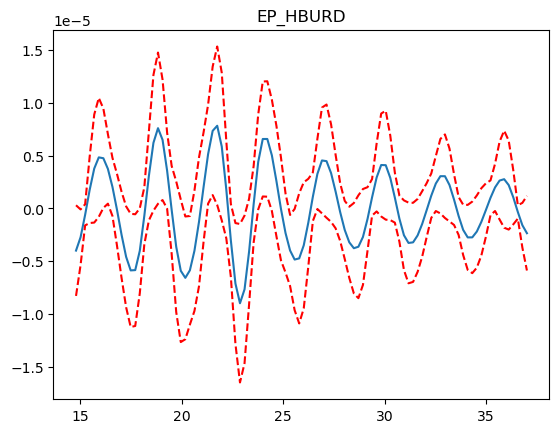

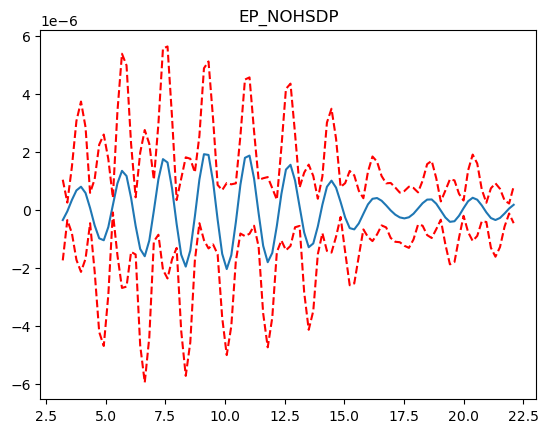

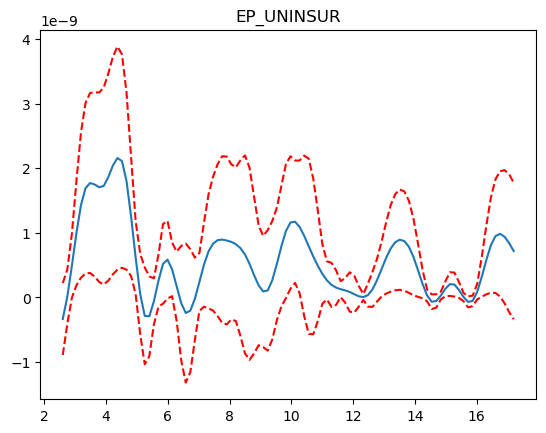

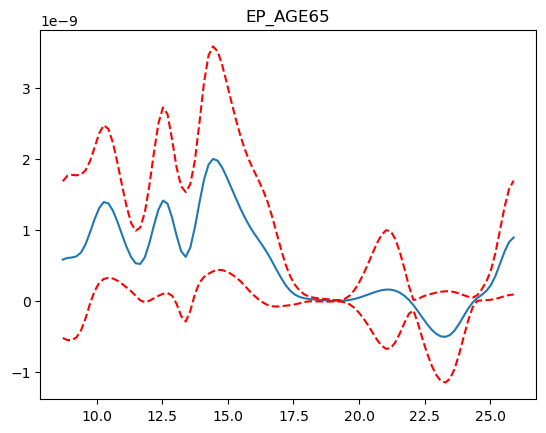

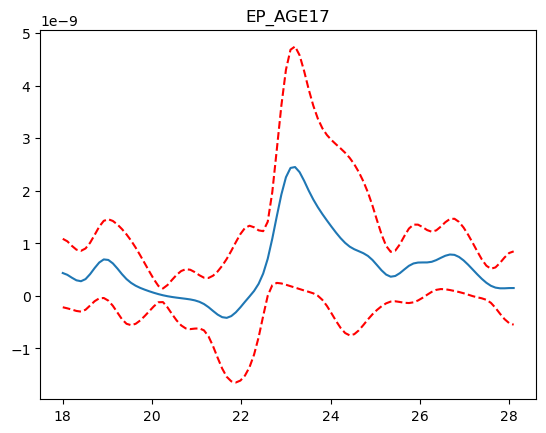

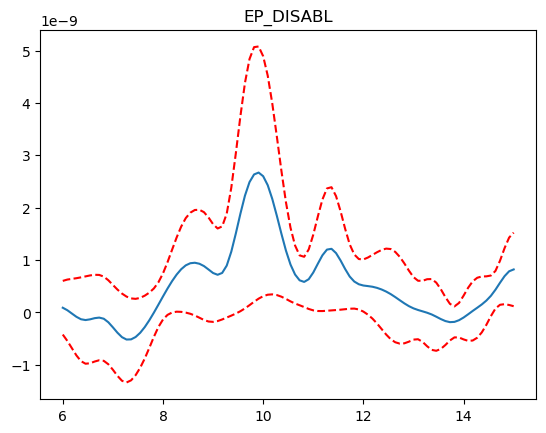

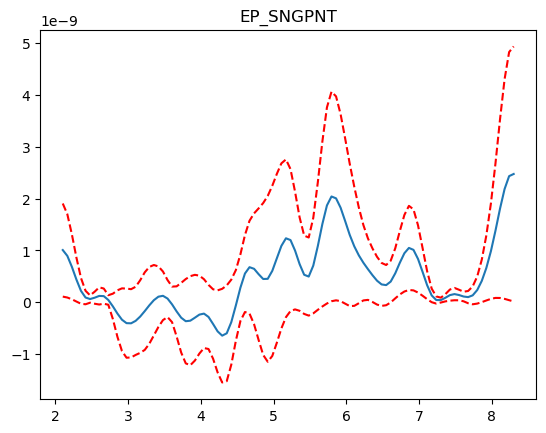

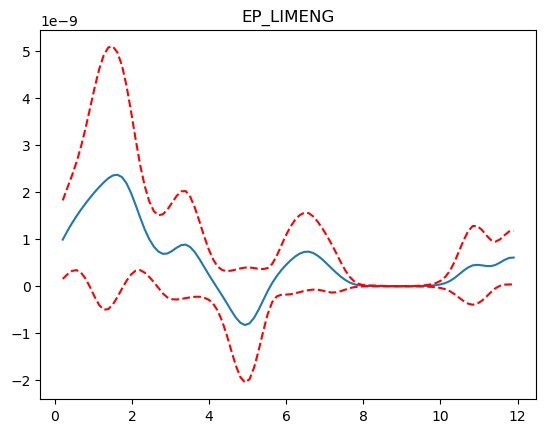

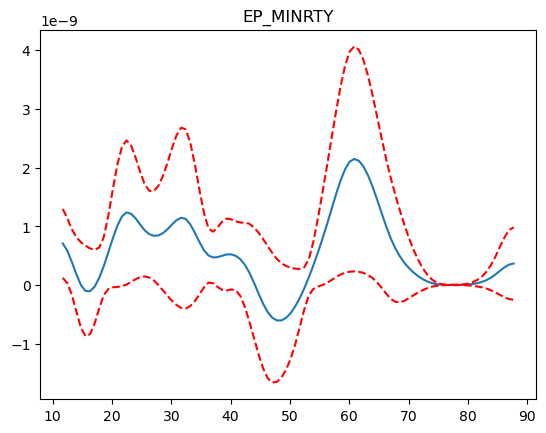

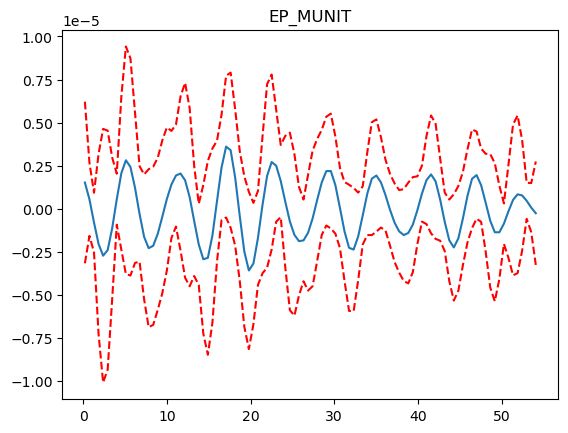

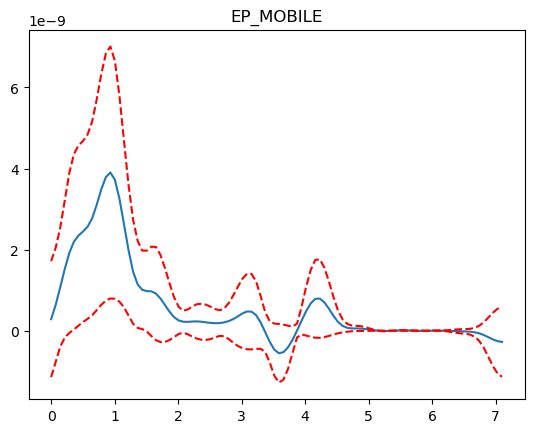

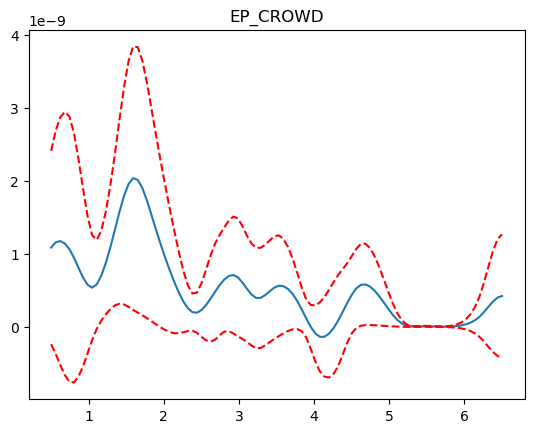

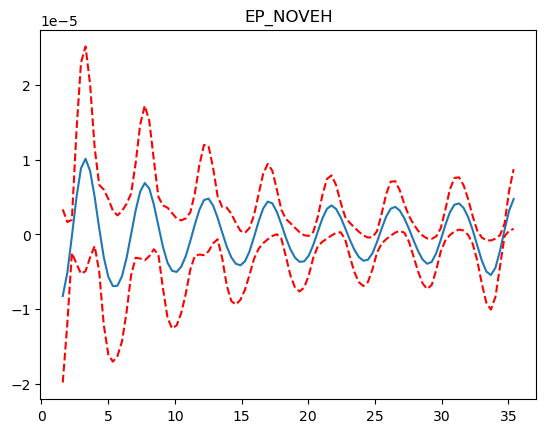

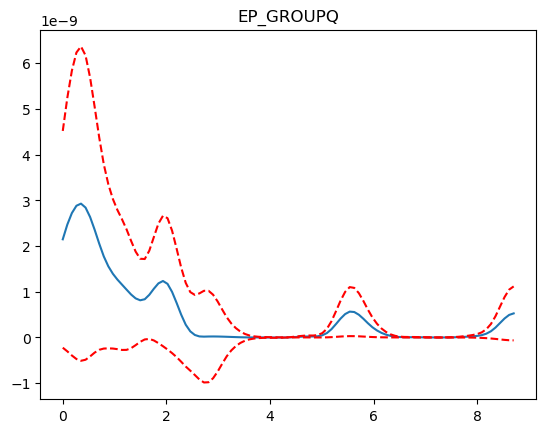

In [30]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(featureNames[i])
    # plt.title(repr(term))
    plt.show()

#### Model 3 - 

In [31]:
from pygam import GAM, LinearGAM, s, f, te

In [32]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [38]:
# search for the best parameters

n_features = 16 # number of features used in the model
lams = np.logspace(-5,5,20) * n_features
splines = 25 # number of splines we will use

In [39]:
# linear GAM for Regression
gam = LinearGAM(n_splines = splines).gridsearch(
                X_train.values, 
                y_train.values,
                lam=lams)

  0% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  5% (1 of 20) |#                        | Elapsed Time: 0:00:00 ETA:   0:00:02
 10% (2 of 20) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:02
 15% (3 of 20) |###                      | Elapsed Time: 0:00:00 ETA:   0:00:02
 20% (4 of 20) |#####                    | Elapsed Time: 0:00:00 ETA:   0:00:03
 25% (5 of 20) |######                   | Elapsed Time: 0:00:01 ETA:   0:00:03
 30% (6 of 20) |#######                  | Elapsed Time: 0:00:01 ETA:   0:00:03
 35% (7 of 20) |########                 | Elapsed Time: 0:00:01 ETA:   0:00:02
 40% (8 of 20) |##########               | Elapsed Time: 0:00:01 ETA:   0:00:02
 45% (9 of 20) |###########              | Elapsed Time: 0:00:01 ETA:   0:00:02
 50% (10 of 20) |############            | Elapsed Time: 0:00:02 ETA:   0:00:02
 55% (11 of 20) |#############           | Elapsed Time: 0:00:02 ETA:   0:00:01
 60% (12 of 20) |##############         

In [40]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     16.9989
Link Function:                     IdentityLink Log Likelihood:                                    -4.1462
Number of Samples:                           17 AIC:                                               44.2902
                                                AICc:                                            -297.8566
                                                GCV:                                                   0.0
                                                Scale:                                                 0.0
                                                Pseudo R-Squared:                                      1.0
Feature Function                  Lam

/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_60885/3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [41]:
print(gam.score(X_test,y_test))

-0.07427121368269085


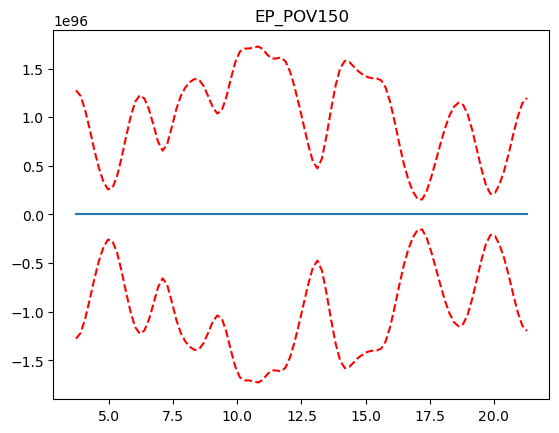

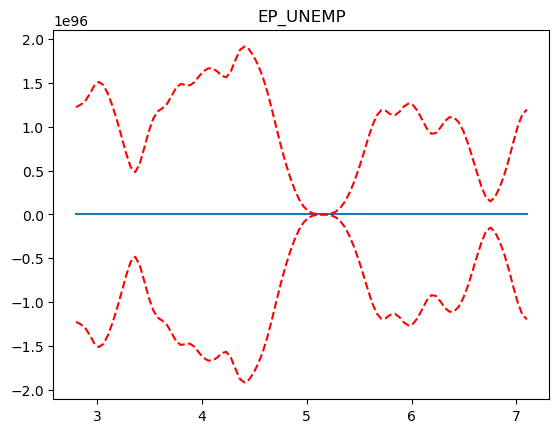

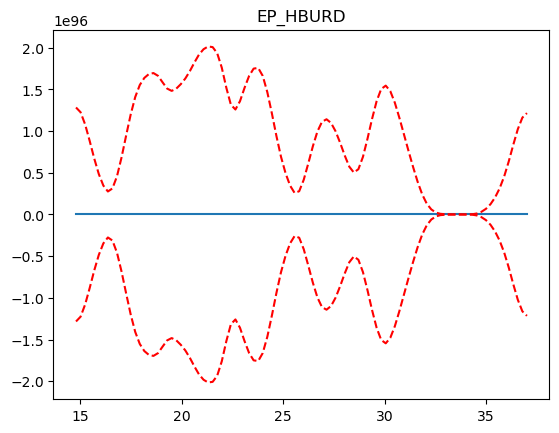

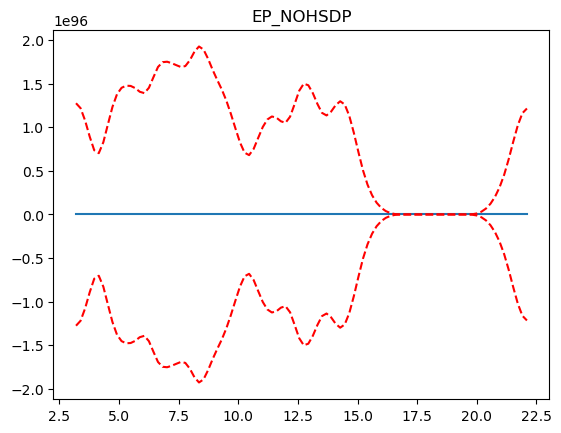

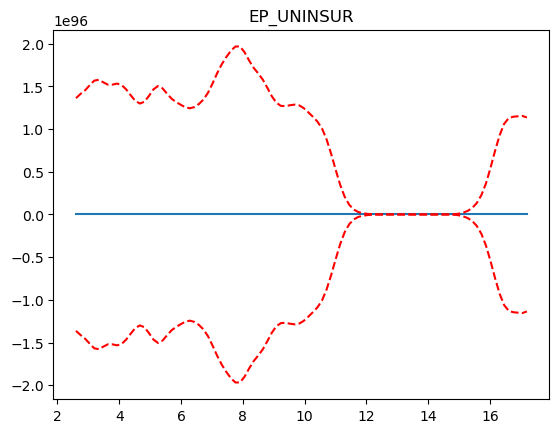

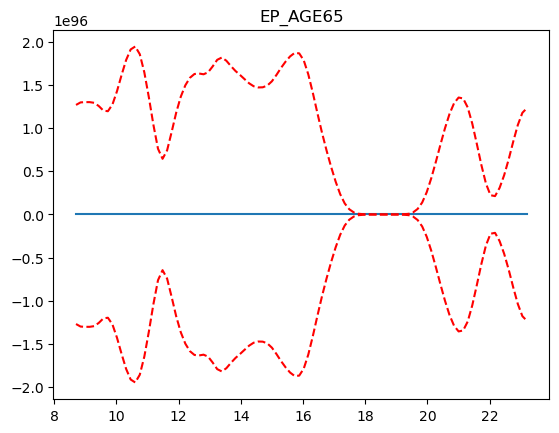

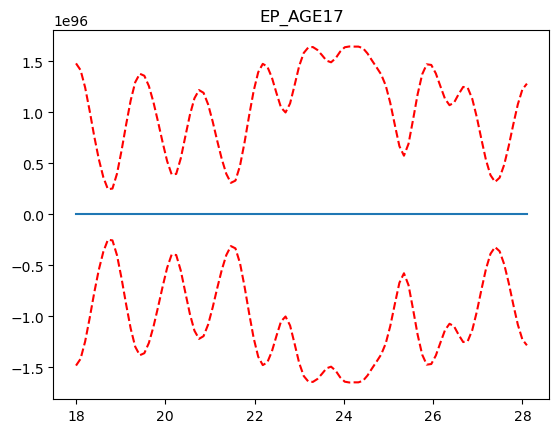

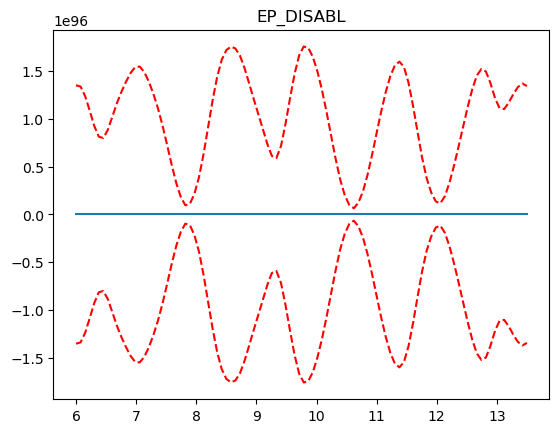

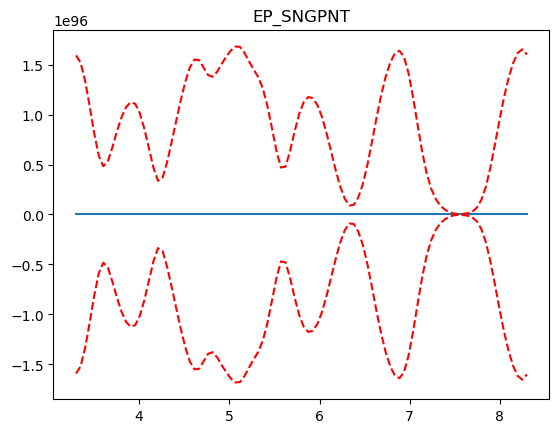

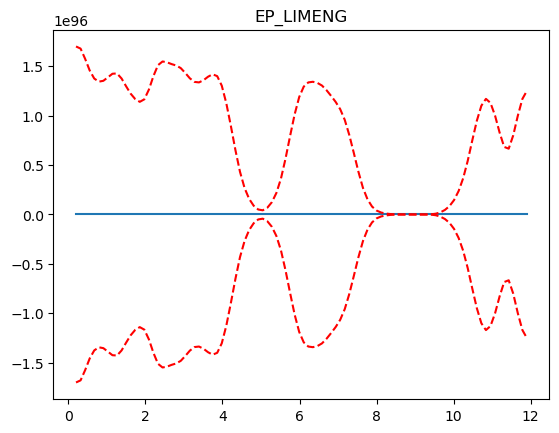

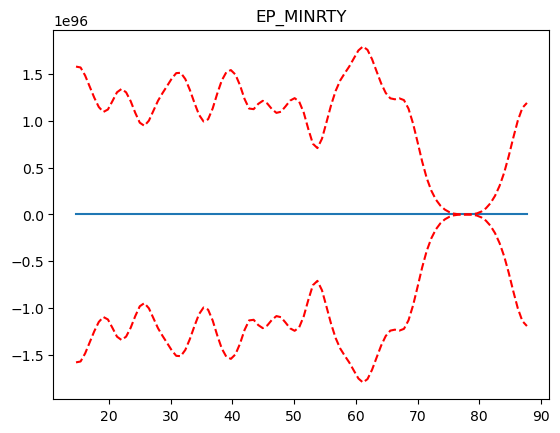

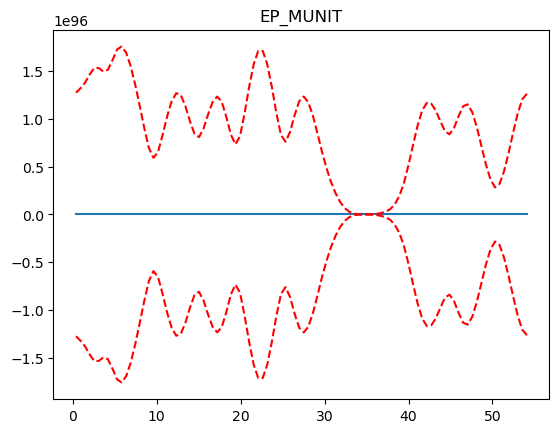

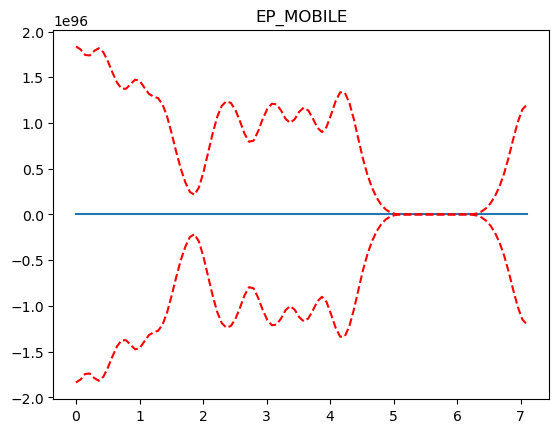

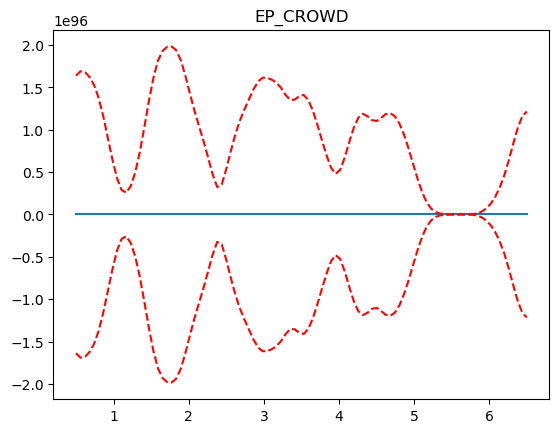

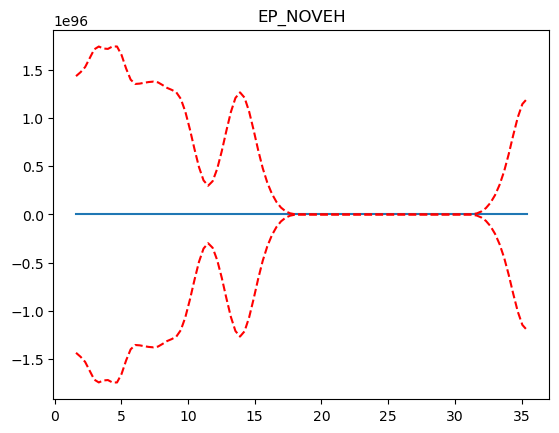

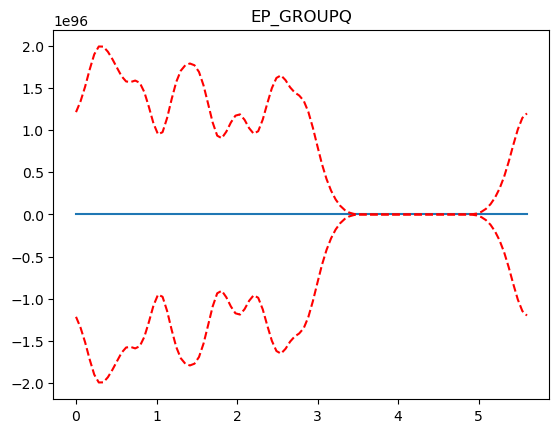

In [42]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(featureNames[i])
    # plt.title(repr(term))
    plt.show()

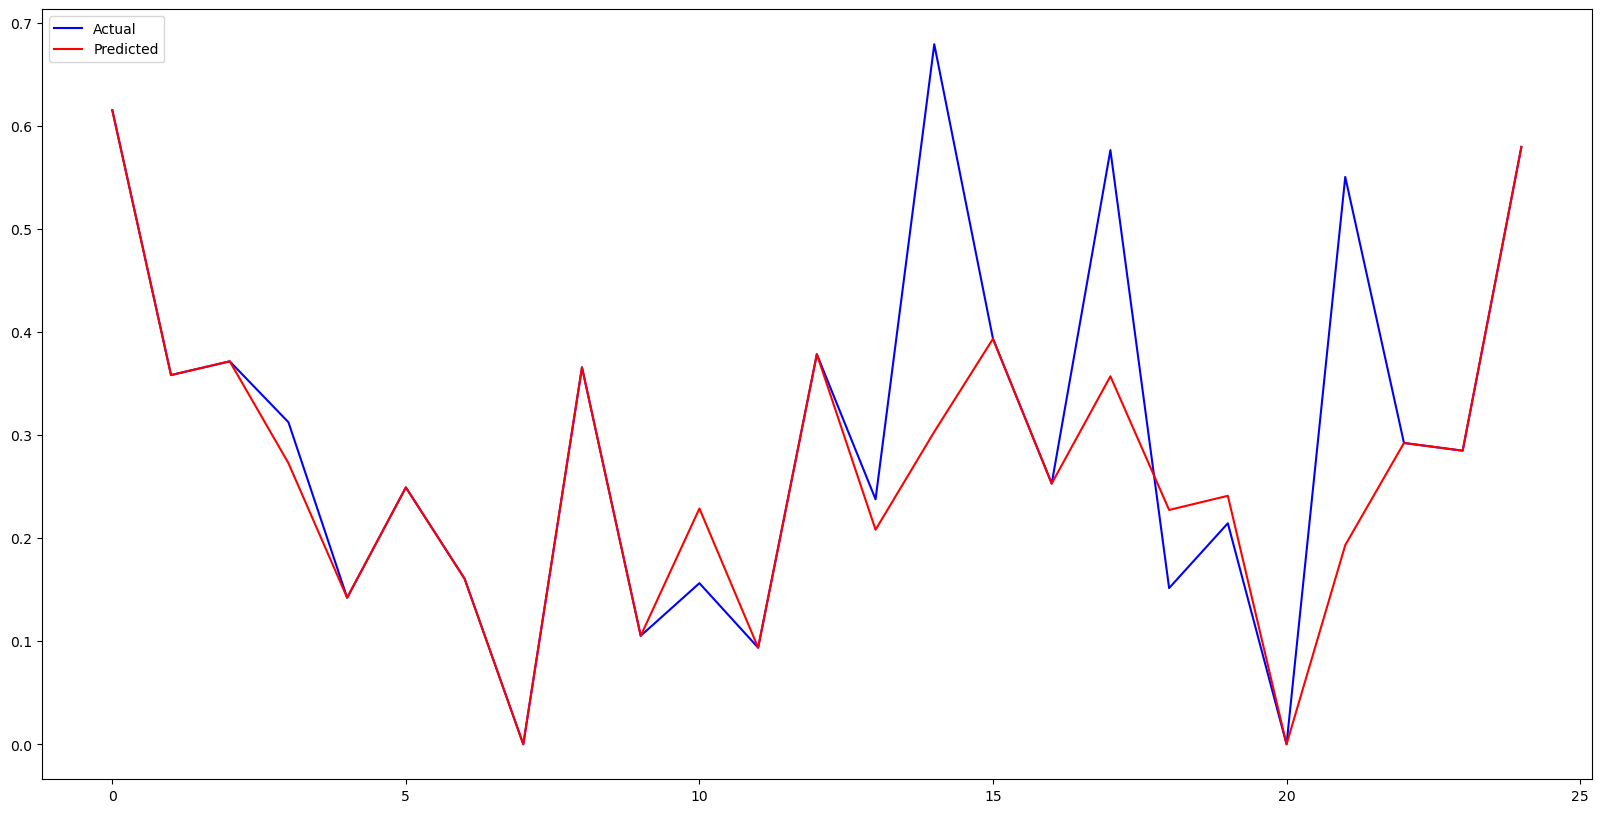

In [43]:
# plot both actual and predicted values on the same graph
y.plot(figsize=(20,10), color='blue', label='Actual')
plt.plot(gam.predict(X), color='red', label='Predicted')
plt.legend(loc='upper left')
plt.show()

#### Model 4 -

In [44]:
dist = np.random.uniform(1e-3,1e3,(100, 16))
n_splines_to_test = 25

In [45]:
gam = LinearGAM(n_splines=n_splines_to_test).gridsearch(X.values, y.values, lam=dist)

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  1% (1 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:18
  2% (2 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:18
  3% (3 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16
  4% (4 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16
  5% (5 of 100) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:15
  6% (6 of 100) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:15
  7% (7 of 100) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:16
  8% (8 of 100) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:16
  9% (9 of 100) |##                      | Elapsed Time: 0:00:01 ETA:   0:00:15
 10% (10 of 100) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:15
 11% (11 of 100) |##                     | Elapsed Time: 0:00:02 ETA:   0:00:17
 12% (12 of 100) |##                    

In [46]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      0.0002
Link Function:                     IdentityLink Log Likelihood:                                   -71.1819
Number of Samples:                           25 AIC:                                              144.3642
                                                AICc:                                             144.5382
                                                GCV:                                                0.1247
                                                Scale:                                              0.1247
                                                Pseudo R-Squared:                                   -2.656
Feature Function                  Lam

/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_60885/3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [48]:
print(gam.score(X_test,y_test))

-3.3590579570694015


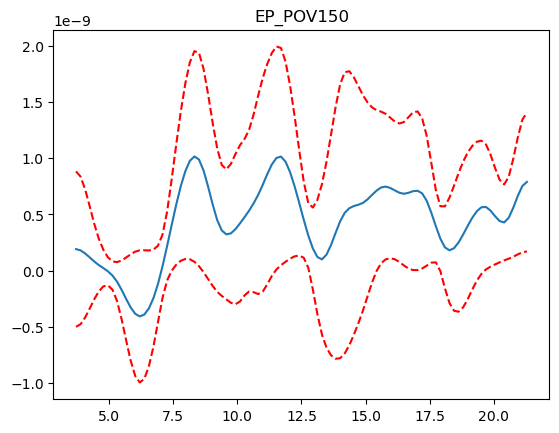

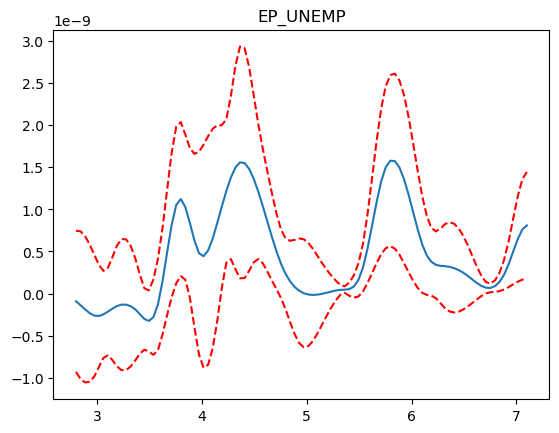

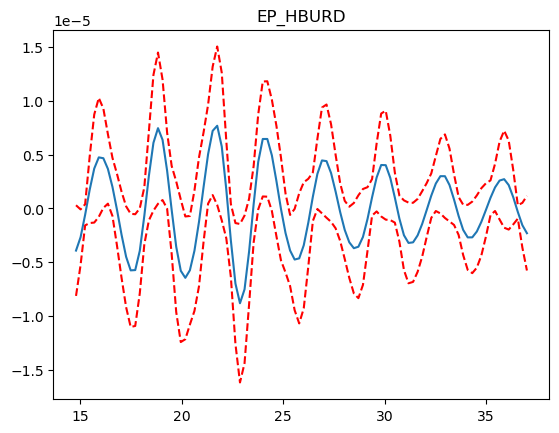

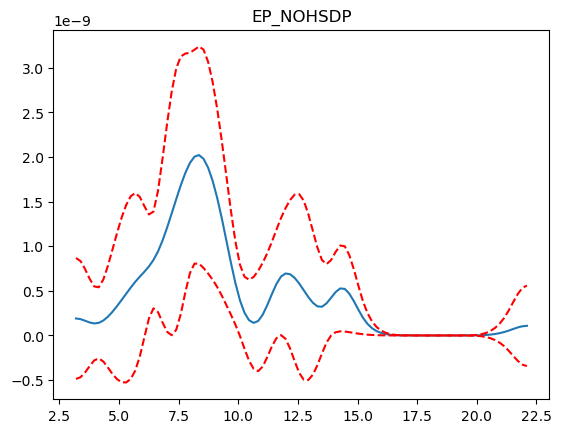

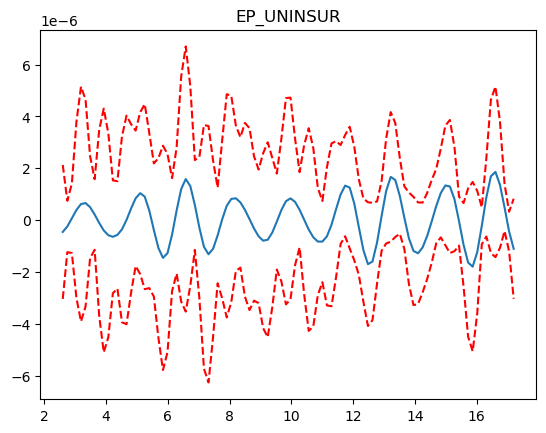

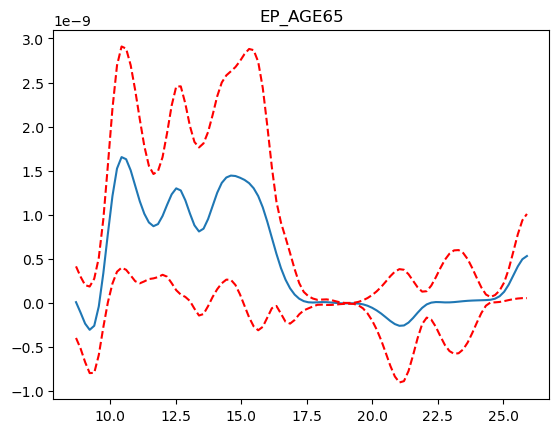

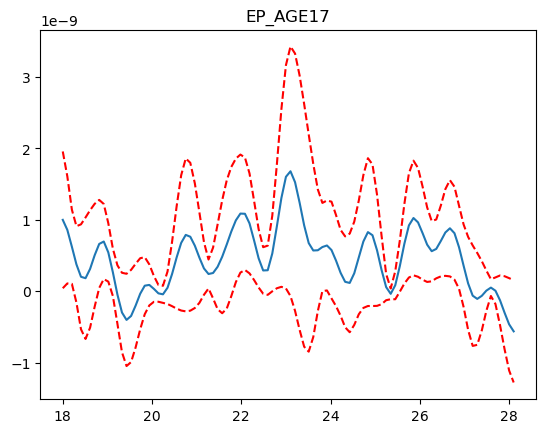

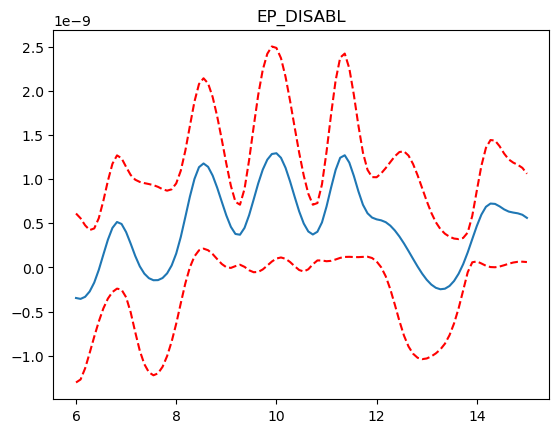

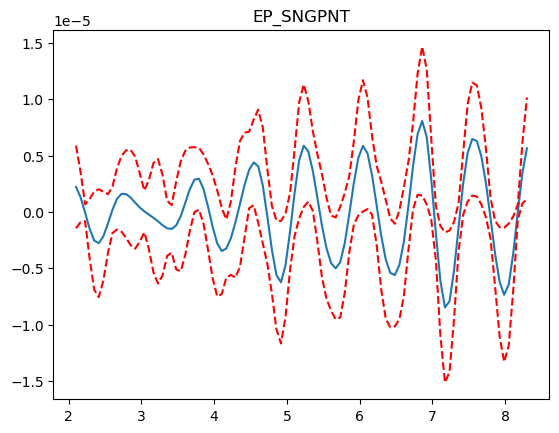

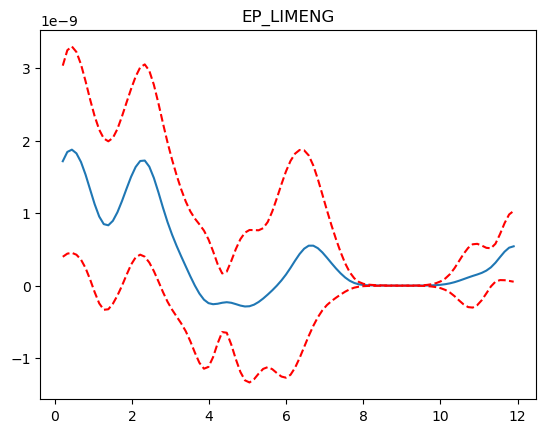

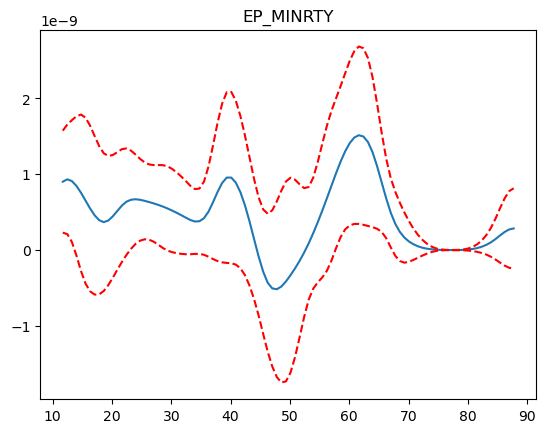

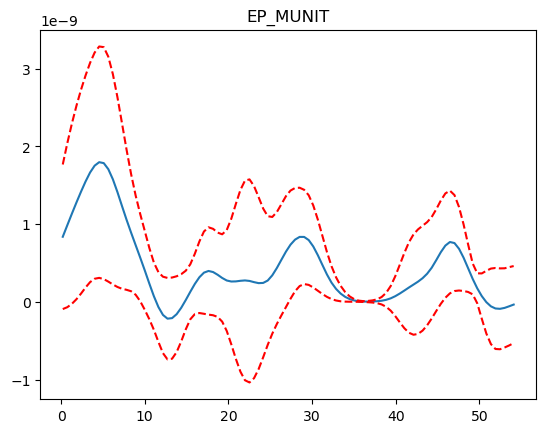

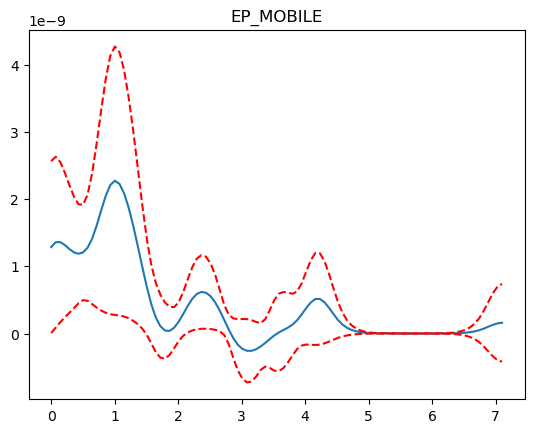

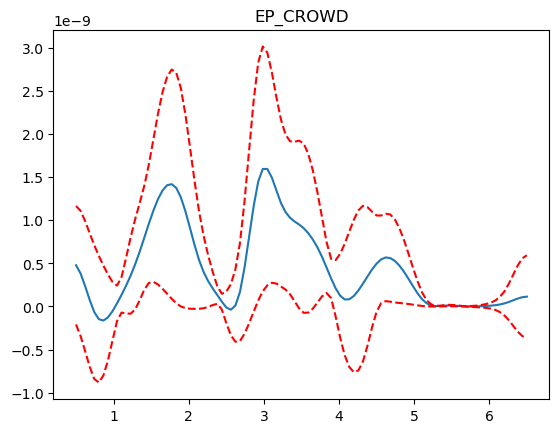

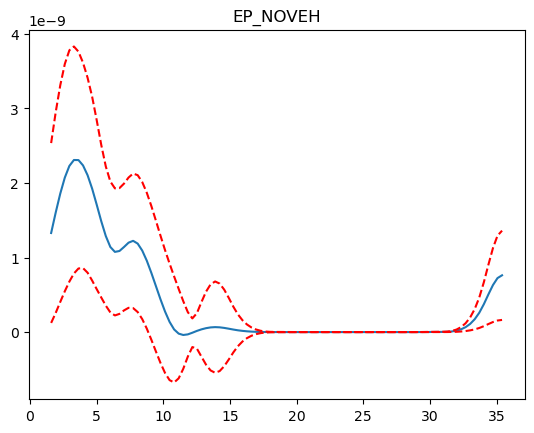

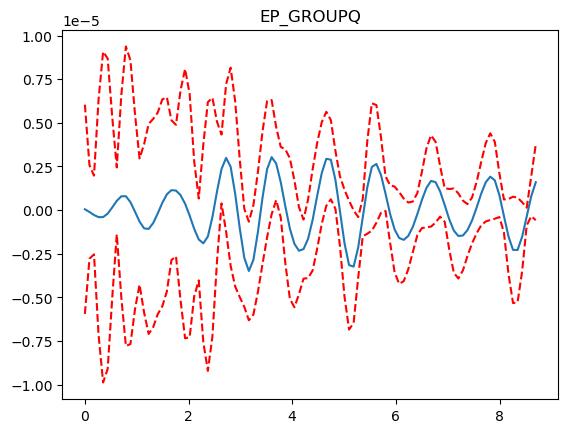

In [47]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(featureNames[i])
    # plt.title(repr(term))
    plt.show()

#### Model 5 - 

In [50]:
from pygam import GAM, s, l, f

In [51]:
gam = GAM(callbacks=['deviance', 'diffs'], distribution='normal', 
   fit_intercept=True, link='identity', max_iter=100, tol=0.0001, verbose=False)

In [52]:
gam.fit(X_train.values, y_train.values)

GAM(callbacks=[Deviance(), Diffs()], distribution=NormalDist(), 
   fit_intercept=True, link=IdentityLink(), max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + intercept,
   tol=0.0001, verbose=False)

In [53]:
gam.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      5.6255
Link Function:                     IdentityLink Log Likelihood:                                  -136.3071
Number of Samples:                           17 AIC:                                              285.8654
                                                AICc:                                             296.6442
                                                GCV:                                                0.0737
                                                Scale:                                              0.0317
                                                Pseudo R-Squared:                                   0.2831
Feature Function                  Lam

/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_60885/3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


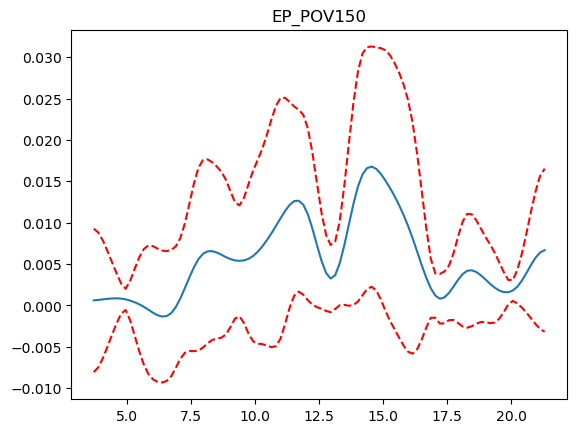

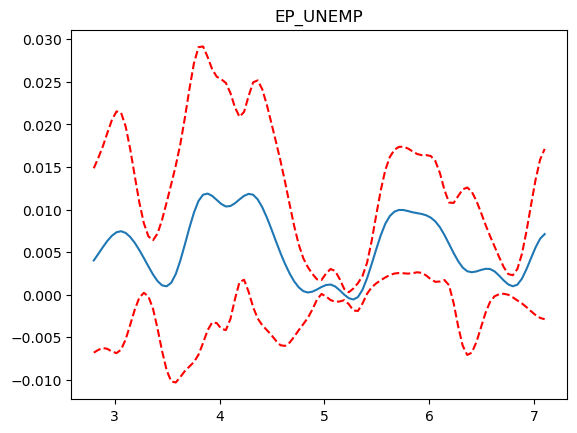

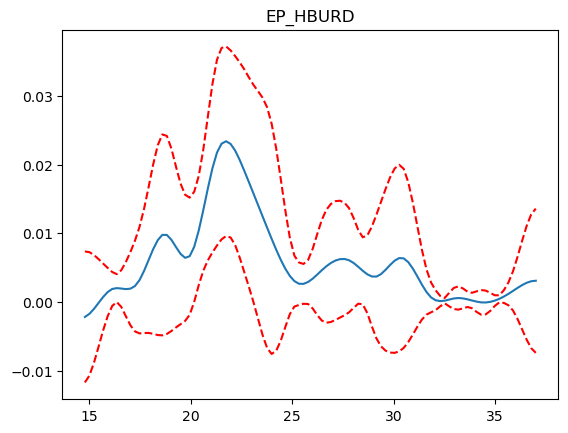

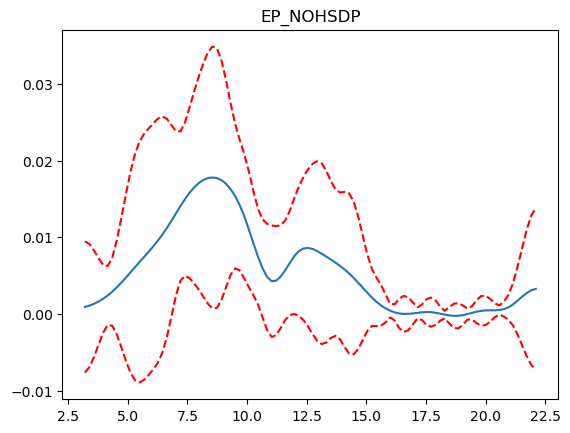

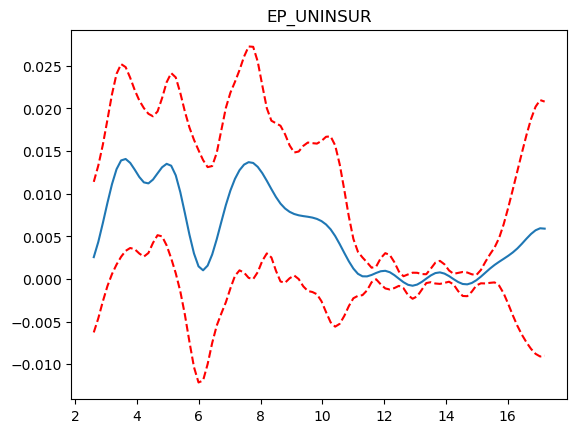

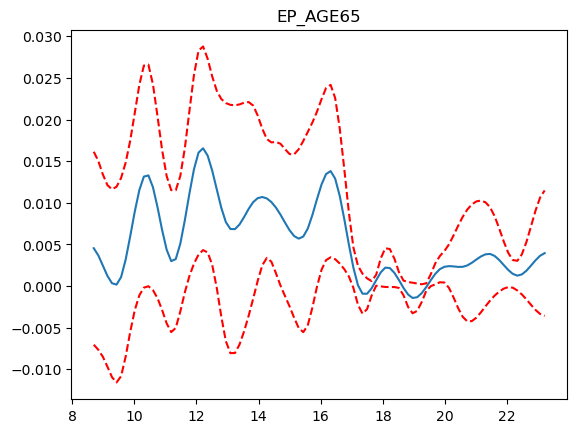

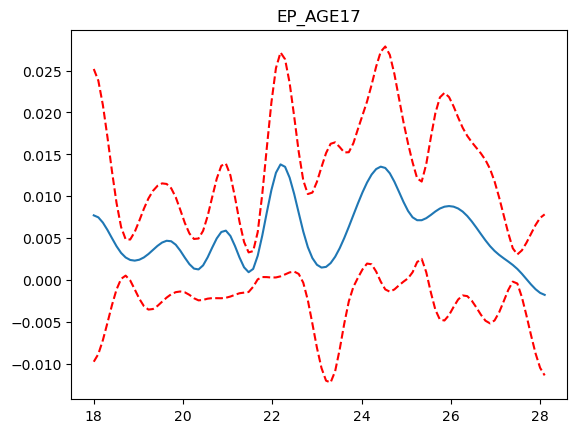

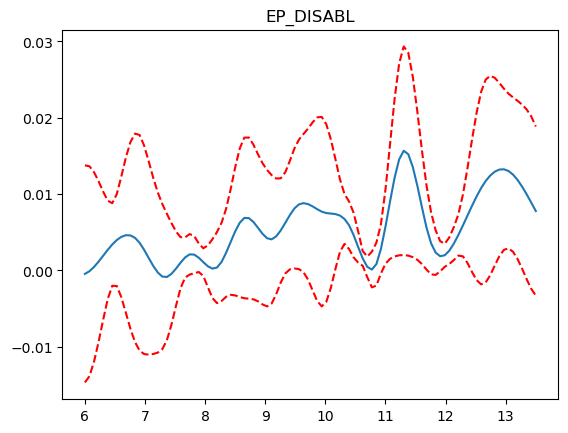

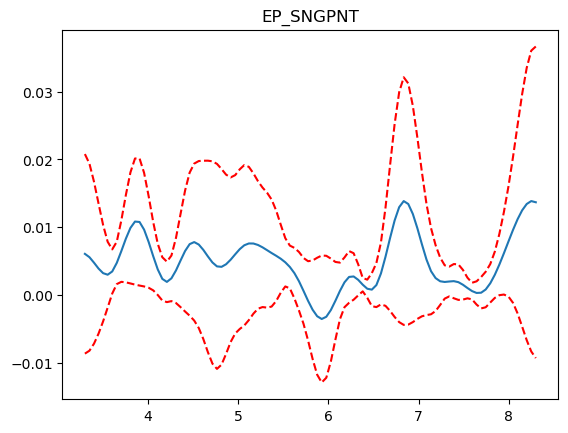

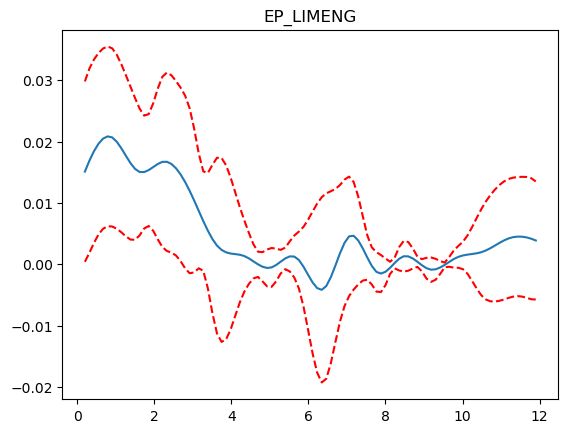

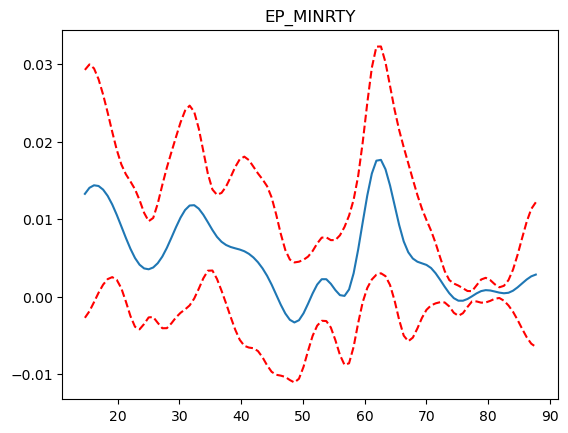

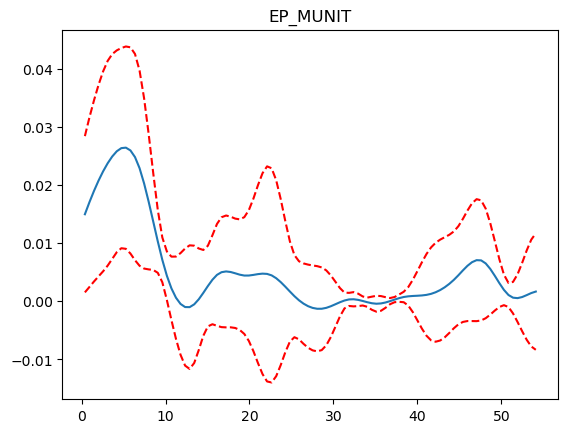

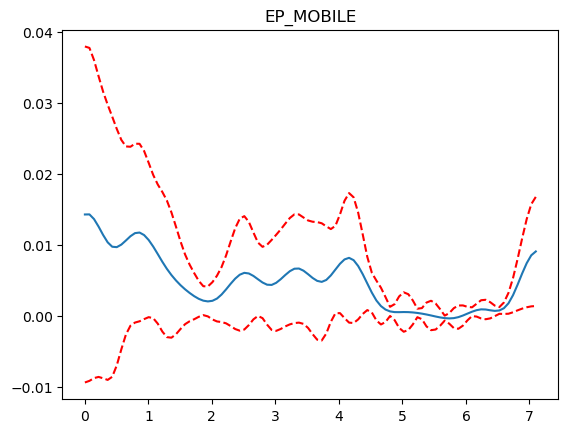

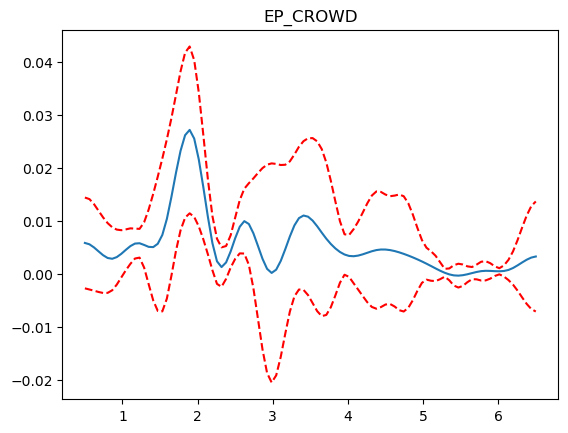

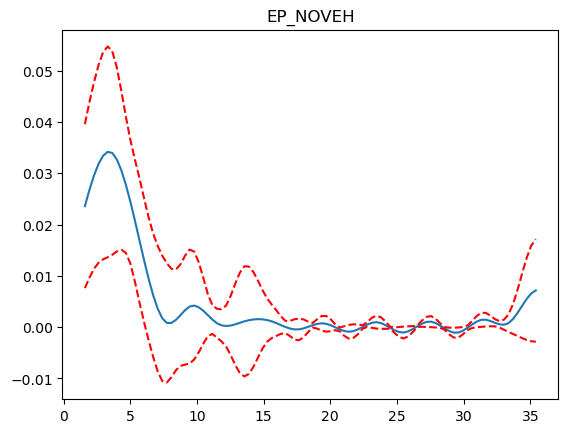

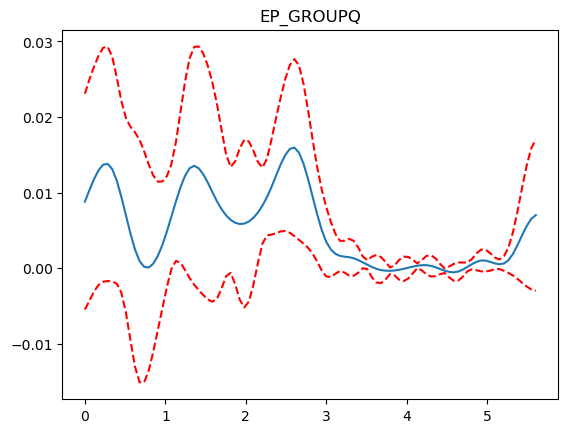

In [54]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(featureNames[i])
    # plt.title(repr(term))
    plt.show()